# Library

In [2]:
# ! pip install wandb opencv-python-headless==4.1.2.30 albumentations torch-summary timm einops joblib icecream  -qq -U

In [3]:
from sklearn.metrics import f1_score
from glob import glob
import pathlib
from pathlib import Path
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pprint import pprint
import urllib.request
import csv
import numpy as np
from einops import rearrange, reduce, repeat
from torch.cuda import amp
from tqdm import tqdm
import wandb
import time
import copy
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import joblib
import gc
import os
from icecream import ic
from sklearn.model_selection import train_test_split
import gc
import cv2
import copy
import time
import random
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import timm

import json

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


from sklearn.metrics import f1_score

# ENV

In [4]:

ENV = 'COLAB'
# ENV = 'KAGGLE'
# ENV = 'SYSTEM'

# Option for Mixed Precision
# FP16 = True
FP16 = False


CONFIG = dict(
    seed=42,
    backbone='tf_efficientnetv2_m',
    embedder=None,
    train_batch_size=8,
    valid_batch_size=16,
    img_size=0,
    img_height=512,
    img_width=384,
    num_epochs=30,
    early_stopping=False,
    early_stopping_step=5,
    learning_rate=1e-5,
    scheduler='CosineAnnealingLR',
    min_lr=1e-6,
    T_max=100,
    num_classes=25,
    weight_decay=1e-6,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    competition='lg',
    _wandb_kernel='deb'
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# SET SEED 

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


set_seed(CONFIG['seed'])


# Read the Data


In [6]:
import wandb
run = wandb.init(project="lg", entity="jiwon7258",
                 config=CONFIG, job_type='train')
dataset = wandb.run.use_artifact(
    'jiwon7258/lg/lg_train:v0', type='dataset')


# Download the artifact's contents
dataset_dir = dataset.download()
dataset_dir = Path(dataset_dir)


In [7]:
TRAIN_PATH = dataset_dir
# TEST_PATH = dataset_dir / 'test'

# Augmentations

In [30]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,
                           rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15,
                   b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(),
        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(),
        ToTensorV2(),
        ], p=1.)
}


# Dataset

In [9]:
train_csv = sorted(glob(str(TRAIN_PATH / '*/*.csv')))
train_jpg = sorted(glob(str(TRAIN_PATH / '*/*.jpg')))
train_json = sorted(glob(str(TRAIN_PATH / '*/*.json')))


crops = []
diseases = []
risks = []
labels = []

for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        crop = sample['annotations']['crop']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        label=f"{crop}_{disease}_{risk}"
    
        crops.append(crop)
        diseases.append(disease)
        risks.append(risk)
        labels.append(label)
        
label_unique = sorted(np.unique(labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in labels] # len = train_len

In [19]:
train_labels

[]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_jpg, train_labels, test_size=0.1, stratify = train_labels)

In [27]:
class CustomDataset(Dataset):
    def __init__(self, train_img, train_label, transforms=None):
        self.imgs = train_img
        self.labels = train_label
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        img_path = self.imgs[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return img, target
        
trainDataset = CustomDataset(X_train, y_train, transforms = data_transforms['train'])
trainDataloader = DataLoader(
    trainDataset, batch_size=CONFIG['train_batch_size'], shuffle=True)

validDataset = CustomDataset(X_val, y_val, transforms = data_transforms['valid'])
validDataloader = DataLoader(validDataset, batch_size = CONFIG['valid_batch_size'], shuffle = True)

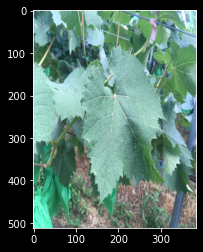

In [29]:
# import matplotlib.pyplot as plt
# for img in trainDataset:
#     # print(img)
#     plt.imshow(img)
#     break

# Model

In [ ]:
class Model(nn.Module):
    def __init__(self, backbone, embedder, pretrained=True):
        super(Model, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.backbone.reset_classifier(0)
        self.n_features = 1280
        self.fc = nn.Linear(self.n_features, CONFIG['num_classes'])

    def forward(self, images):
        # features = (bs, embedding_size)
        features = self.backbone(images)
        # outputs  = (bs, num_classes)
        output = self.fc(features)
        return output


model = Model(CONFIG['backbone'], CONFIG['embedder'], pretrained = True)
model.to(CONFIG['device'])
;

In [ ]:
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])


In [ ]:
def criterion(logits: torch.tensor, targets: torch.tensor):
    return nn.CrossEntropyLoss()(logits.view(-1,CONFIG['num_classes']), targets.view(-1))

   # Training Function

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    # train 모드로 변경
    model.train()

    # for the Mixed Precision
    # Pytorch 예제 : https://pytorch.org/docs/stable/notes/amp_examples.html#amp-examples
    if(FP16):
        scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0
    step_acc = 0
    accuracy = 0
    f1 = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))

    for step, (img, target) in bar:
        img = img.to(device)
        target = target.to(device)

        batch_size = img.shape[0]

        if(FP16):
            with amp.autocast(enabled=True):
                logits = model(img)
                loss = criterion(logits, target)

                # loss를 Scale
                # Scaled Grdients를 계산(call)하기 위해 scaled loss를 backward()
                scaler.scale(loss).backward()
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
                # otherwise, optimizer.step() is skipped.
                scaler.step(optimizer)

                # Updates the scale for next iteration.
                scaler.update()

        else:
            logits = model(img)
            loss = criterion(logits, target)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

        # logits (bs, seq_len, VOCAB_SIZE)
        # trg_output (bs, seq_len)

        # zero the parameter gradients
        optimizer.zero_grad()

        # change learning rate by Scheduler
        if scheduler is not None:
            scheduler.step()

        # loss.item()은 loss를 Python Float으로 반환
        # loss.item()은 batch data의 average loss이므로, sum of loss를 구하기 위해 batch_size를 곱해준다
        running_loss += loss.item() * batch_size
        dataset_size += batch_size
        
        # logits
        logits = logits.detach().cpu()

        # acc, f1
        output = np.argmax(torch.softmax(logits, dim = -1), axis = -1)
        step_acc = np.mean(
            output.view(-1).numpy() == target.view(-1).detach().cpu().numpy())
        step_f1 = f1_score(output.view(-1).numpy(),
                           target.view(-1).detach().cpu().numpy(),average='macro')
        accuracy += step_acc
        f1 += step_f1

        # loss
        train_loss = running_loss / dataset_size

        bar.set_postfix(
            Epoch=epoch, Train_Loss=train_loss, LR=optimizer.param_groups[0]["lr"], accuracy=accuracy / np.float(
                step+1), f1 = f1 / np.float(step+1)
        )

        # break

    accuracy /= len(dataloader)
    f1 /= len(dataloader)
    # Garbage Collector
    gc.collect()

    return train_loss, accuracy, f1


   # Validation Function

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0
    accuracy = 0
    f1 = 0


    bar = tqdm(enumerate(dataloader), total=len(dataloader))

    for step, (img, target) in bar:
        img = img.to(device)
        target = target.to(device)

        batch_size = img.shape[0]

        logits = model(img)
        loss = criterion(logits, target)

        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        # 실시간으로 정보를 표시하기 위한 epoch loss
        val_loss = running_loss / dataset_size

        # logits
        logits = logits.detach().cpu()
        
        output = np.argmax(torch.softmax(logits, dim=-1), axis=-1)
        step_acc = np.mean(
            output.view(-1).numpy() == target.view(-1).detach().cpu().numpy())
        step_f1 = f1_score(output.view(-1).numpy(),
                           target.view(-1).detach().cpu().numpy(), average='macro')
        accuracy += step_acc
        f1 += step_f1


        bar.set_postfix(
            Epoch=epoch, Valid_Loss=val_loss, LR=optimizer.param_groups[0]["lr"], accuracy=accuracy / np.float(
                step+1), f1 = f1 / np.float(step+1)
        )

        # break

    accuracy /= len(dataloader)
    f1 /= len(dataloader)

    gc.collect()

    return val_loss, accuracy, f1


In [ ]:
def run_training(
    model,
    optimizer,
    scheduler,
    device,
    num_epochs,
    metric_prefix="",
    file_prefix="",
    early_stopping=True,
    early_stopping_step=10,
):
    # To automatically log graidents
    wandb.watch(model, log_freq=100)

    if torch.cuda.is_available():
        print("[INFO] Using GPU:{}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    early_stop_counter = 0

    # num_epochs만큼, train과 val을 실행한다
    for epoch in range(1, num_epochs + 1):
        gc.collect()

        train_train_loss, train_accuracy, train_f1 = train_one_epoch(
            model,
            optimizer,
            scheduler,
            dataloader=trainDataloader,
            device=device,
            epoch=epoch,
        )

        val_loss, val_accuracy, val_f1 = valid_one_epoch(
            model, validDataloader, device=device, epoch=epoch
        )

        history[f"{metric_prefix}Train Loss"].append(train_train_loss)
        history[f"{metric_prefix}Train Accuracy"].append(train_accuracy)
        history[f"{metric_prefix}Train F1"].append(train_f1)
        history[f"{metric_prefix}Valid Loss"].append(val_loss)
        history[f"{metric_prefix}Valid Accuracy"].append(val_accuracy)
        history[f"{metric_prefix}Valid F1"].append(val_f1)


        # Log the metrics
        wandb.log(
            {
                f"{metric_prefix}Train Loss": train_train_loss,
                f"{metric_prefix}Valid Loss": val_loss,
                f"{metric_prefix}Train Accuracy": train_accuracy,
                f"{metric_prefix}Valid Accuracy": val_accuracy,
                f"{metric_prefix}Train F1" : train_f1,
                f"{metric_prefix}Valid F1" : val_f1,
            }
        )

        print(f"Valid Loss : {val_loss}")

        # deep copy the model
        if val_loss <= best_loss:
            early_stop_counter = 0

            print(
                f"Validation Loss improved( {best_loss} ---> {val_loss}  )"
            )

            # Update Best Loss
            best_loss = val_loss

            # Update Best Model Weight
            # run.summary['Best RMSE'] = best_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            PATH = "{}epoch{:.0f}_Loss{:.4f}.bin".format(
                file_prefix, epoch, best_loss)
            torch.save(model.state_dict(), PATH)
            torch.save(model.state_dict(),
                       f"{file_prefix}best_{epoch}epoch.bin")
            # Save a model file from the current directory
            wandb.save(PATH)

            print(f"Model Saved")

        elif early_stopping:
            early_stop_counter += 1
            if early_stop_counter > early_stopping_step:
                break

        # break

    end = time.time()
    time_elapsed = end - start
    print(
        "Training complete in {:.0f}h {:.0f}m {:.0f}s".format(
            time_elapsed // 3600,
            (time_elapsed % 3600) // 60,
            (time_elapsed % 3600) % 60,
        )
    )
    print("Best Loss: {:.4f}".format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history


 # Run training

In [ ]:
MODEL_NAME = 'epoch6_Loss0.1077.bin'
wandb.restore(MODEL_NAME, 'jiwon7258/lg/179twrcb', root='./')
model.load_state_dict(torch.load(MODEL_NAME, map_location=CONFIG['device']))


In [ ]:
run_training(
    model=model,
    optimizer=optimizer,
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer, T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr']),
    device=device,
    num_epochs=CONFIG['num_epochs'],
    metric_prefix="",
    file_prefix="",
    early_stopping=CONFIG['early_stopping'],
    early_stopping_step=CONFIG['early_stopping_step'],
)


In [ ]:
torch.save(model.state_dict(), 'final.bin')
wandb.save('final.bin')
